Load libraries and data.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import functools

train=np.loadtxt('sincTrain25.dt')
trainx=train[:,0]
trainy=train[:,1]
valid=np.loadtxt('sincValidate10.dt')
valx=valid[:,0]
valy=valid[:,1]

Let's plot the training data and validation data (they are generated from the function sinc(x)=sin(x)/x)so we have an idea of what it looks like.

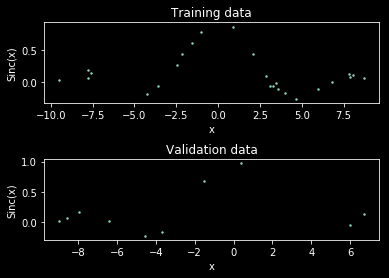

In [2]:
%matplotlib inline
plt.style.use("dark_background")
fig, ax = plt.subplots(2)
fig.subplots_adjust(hspace=0.7)
ax[0].scatter(trainx, trainy, s=2)
ax[0].set_title('Training data')
ax[0].set_ylabel('Sinc(x)')
ax[0].set_xlabel('x')
ax[1].scatter(valx, valy, s=2)
ax[1].set_title('Validation data')
ax[1].set_ylabel('Sinc(x)')
ax[1].set_xlabel('x')
plt.show()

Define neural network function and gradient descent function

In [4]:
def neural_network(x, w, activation_function, classify = False, has_ones = False):
    w0 = w[0]
    w1 = w[1]
    if len(x.shape)<1:
        x = x.reshape(1,1)
    N = x.shape[0]
    if not has_ones:
        x = np.c_[np.ones(N), x]
    a = x@w0 # dimenson is d*M where M is number of columns in w0, i.e. number of neurons
    if activation_function == 'relu':
        z = relu(a)
    elif activation_function == 'softsign':
        z = a/(1+np.abs(a))
    z = np.c_[np.ones(z.shape[0]), z] # ones for bias
    a2 = z@w1
    if not classify:
        z2 = z@w1
    else:
        z2 = exp(z)/(exp(z)+1)
    return(dict(first_mult = a, first_mult_nonlin = z, second_mult = a2, output = z2))

def relu(x):
    zeroes = np.zeros(x.shape)
    zeroes[x>0] = x[x>0]
    return(zeroes)

def relu_grad(x):
    grad = (x > 0)*1
    return(grad)

def nn_grad(x, y, a, z, out, w, activation_function):
    '''y must be an array of dimension at least 2'''
    w_out = w[1]
    N = x.shape[0]
    delta_outs = out-y # N*1
    qq = np.zeros(21)
    delta_outs_repeated = np.repeat((out-y), w_out.shape[0], axis=1) # N*(n_hidden+1)
    output_grad = np.sum(np.multiply(delta_outs, z), axis=0)/N # gradient of output unit
    if len(output_grad.shape)<2:
        output_grad = output_grad.reshape(output_grad.shape[0], 1)
    if activation_function == 'relu':
        hidden_activation_deriv = relu_grad(a)
    elif activation_function == 'softsign':
        hidden_activation_deriv = 1/((1+np.abs(a))**2)
    delta_hidden_sum_parts = delta_outs@w_out.T # this must be a sum with more than 1 output neuron
    delta_hidden_sum_parts = delta_hidden_sum_parts[:,1:] # removing bias column
    delta_hidden = hidden_activation_deriv*delta_hidden_sum_parts
    hidden_grad = 0
    for i in range(N):
        vector_of_deltas = delta_hidden[i,:]
        vector_of_deltas = vector_of_deltas.reshape(a.shape[1],1)
        grad_element = x[i,:]*vector_of_deltas
        hidden_grad += grad_element/N
    return([hidden_grad.T, output_grad])

def nn_gradient_descent(x_train, y_train, x_val, y_val, n_hidden, rate, iterations, patience,
                       verbose, weights, initialization_factors, activation_function):
    if len(y_train.shape)==1:
        y_train = y_train.reshape(y_train.shape[0], 1)
    if len(y_val.shape)==1:
        y_val = y_val.reshape(y_val.shape[0], 1)
    if len(x_train.shape)==1:
        x_train = x_train.reshape(x_train.shape[0], 1)
    K = y_train.shape[1]
    D = x_train.shape[1]
    N = x_train.shape[0]
    x_train = np.c_[np.ones(N), x_train, ]
    # initialize weights
    if initialization_factors == None:
        initialization_factors = [np.sqrt(2/(D+1 + n_hidden)), np.sqrt(2/(n_hidden+1 + K))]
    if weights == None:
        w_hidden0 = np.random.normal(0, 1, (D+1, n_hidden)) * initialization_factors[0]
        w_out0 = np.random.normal(0, 1, (n_hidden+1, K)) * initialization_factors[1]
    w_hidden1 = None
    w_out1 = None
    w_best = None
    
    patience_counter = patience
    train_loss = []
    val_loss = []
    gradient_norm = []
    max_iter = iterations
    while iterations > 0 and patience_counter >0:
        w=[w_hidden0, w_out0]
        nn_outs_train = neural_network(x_train, w, activation_function, has_ones=True)
        a = nn_outs_train['first_mult']
        z = nn_outs_train['first_mult_nonlin']
        out = nn_outs_train['output']
        train_error = 0.5*np.sum((y_train - out)**2)/N
        if len(out.shape)<2:
            out=out.reshape(y_train.shape[0], 1) # reshaping to get broadcasting to work later
        train_loss.append(train_error)
        delta_outs = (out-y_train) # N*1
        grads = nn_grad(x=x_train, y=y_train, a=a, z=z, out=out, w=w, activation_function=activation_function)
        hidden_grad = grads[0]
        output_grad = grads[1]
        w_hidden1 = w_hidden0 - rate*hidden_grad #/N
        w_out1 = w_out0 - rate*output_grad #/N
        val_out = neural_network(x_val, w, activation_function=activation_function)['output']
        val_error = 0.5*np.sum((y_val - val_out)**2)/x_val.shape[0]
        iterations -= 1
        if verbose: 
            print('iterations: ', max_iter-iterations)
            print('Training loss: {}, Validation loss: {}'.format(train_error, val_error))
        if len(val_loss)>1:
            if val_error < min(val_loss):
                if verbose: 
                    print('new best w')
                w_best = w
                patience_counter = patience
            elif val_error >= val_loss[-1]:
                patience_counter -= 1
        val_loss.append(val_error)
        w_out0 = w_out1
        w_hidden0 = w_hidden1
        gradient_norm_i = np.sqrt(np.sum(np.concatenate([hidden_grad.flatten(), output_grad.flatten()])**2))
        gradient_norm.append(gradient_norm_i)
    if w_best == None:
        w_best = [w_hidden0, w_out0]
    return(dict(weights=w_best, train_loss=train_loss, val_loss=val_loss, gradient_norm=gradient_norm,
               iterations=max_iter-iterations))


Put the things into a class.

In [5]:
class NNregressor_onelayer:
    def __init__(self, activation_function, weights=None):
        self.weights = weights
        self.activation_function = activation_function
    def estimate_weights(self, trainx, trainy, valx, valy, n_hidden, rate, iterations, patience, verbose,
                        weight_initialization_factors):
        training_results = nn_gradient_descent(trainx, trainy, valx, valy, n_hidden, 
                                           rate, iterations, patience, verbose,
                                           self.weights, weight_initialization_factors,
                                               activation_function = self.activation_function)
        self.weights = training_results['weights']
        self.training_loss = training_results['train_loss']
        self.validation_loss = training_results['val_loss']
        self.gradient_norm = training_results['gradient_norm']
        self.iterations = training_results['iterations']
    def predict(self, x):
        predictions = neural_network(x, self.weights, activation_function = self.activation_function)
        return(predictions['second_mult'].ravel())

First we need to validate the gradient. We make up some random weights and calculate some outputs.

In [6]:
np.random.seed(84)
wtest1=np.random.normal(0,1,(2,20))
wtest2=np.random.normal(0,1,(21,1))
test_out=neural_network(trainx,[wtest1,wtest2], 'relu')
test_a = test_out['first_mult']
test_z = test_out['first_mult_nonlin']
test_pred = test_out['second_mult']
test_error = 0.5*np.sum((test_pred - trainy.reshape(trainy.shape[0], 1))**2)/25
test_grad = nn_grad(np.c_[np.ones(25), trainx.reshape(25,1)], trainy.reshape(25,1), 
                    test_a, test_z, test_pred, [wtest1, wtest2], 'relu')
test_error

173.37861170911933

In [20]:
w_flat = np.concatenate([wtest1.flatten(), wtest2.flatten()])

In [162]:
from scipy import optimize

def rebuild_from_shapes(flat_vector, shapes):
    lengths = [0] + [functools.reduce(lambda x,y: x*y, i) for i in shapes]
    subs = []
    for i in range(len(lengths)-1):
        index_1 = lengths[i]
        index_2 = lengths[i]+lengths[i+1]
        subs.append(flat_vector[index_1:index_2])
    for i,_ in enumerate(subs):
        subs[i] = subs[i].reshape(shapes[i])
    return(subs)

def nn_flat(w_flat, shapes, x, y, activation_function='relu', classify=False):
    w_subs = rebuild_from_shapes(w_flat, shapes)
    outputs = neural_network(x, w_subs, 'relu')['output']
    if not classify:
        error = 0.5*np.sum((outputs-y.reshape(y.shape[0], 1))**2)/y.shape[0]
    else:
        error = np.sum(y*np.log(outputs)+(1-y)*np.log(1-outputs))/y.shape[0]
    return(error)

def gradient_checker(w, x, y, activation_function='relu', classify=False):
    if len(x.shape)<1:
        x = x.reshape(1,1)
    if len(y.shape)==1:
        y = y.reshape(y.shape[0], 1)
    shapes = [i.shape for i in w]
    nn_outs = neural_network(x, w, activation_function)
    a = nn_outs['first_mult']
    z = nn_outs['first_mult_nonlin']
    out = nn_outs['output']
    x_ones = np.c_[np.ones(x.shape[0]), x]
    true_grad = nn_grad(x_ones, y, a, z, out, w, activation_function)
    flat_w = np.concatenate([i.flatten() for i in w])
    approx_grad = optimize.approx_fprime(flat_w, nn_flat, np.sqrt(np.finfo(float).eps),
                                         shapes, x, y)
    approx_grad_split = rebuild_from_shapes(approx_grad, shapes)
    return(dict(true_grads = true_grad, approx_grads = approx_grad_split))

def gradient_quotients(w, x, y, zero_division = np.sqrt(np.finfo(float).eps), 
                      activation_function='relu', classify=False):
    gradients = gradient_checker(w, x, y, activation_function, classify)
    quotients = []
    for i,j in zip(gradients['true_grads'], gradients['approx_grads']):
        quotients.append((i+zero_division)/(j+zero_division))
    return(quotients)
    

In [163]:
print(nn_flat(w_flat, [wtest1.shape, wtest2.shape], trainx, trainy))
print(np.finfo(float).eps)
print(epsilon)

173.37861170911933
2.220446049250313e-16
1.4901161193847656e-08


In [164]:
test_grad_check = gradient_checker([wtest1, wtest2], trainx, trainy)

In [165]:
gradient_quotients([wtest1, wtest2], trainx, trainy)

[array([[0.99999884, 0.99999992, 0.9999999 , 1.00000059, 1.        ,
         1.00000003, 1.00000001, 0.99999987, 1.00000005, 0.99998912,
         0.99999996, 1.00000002, 1.00000031, 0.99999989, 1.0000001 ,
         0.99999832, 0.9999999 , 0.99999944, 1.00000002, 1.00000001],
        [1.00000003, 1.00000001, 0.99999999, 0.99999998, 1.        ,
         1.00000003, 1.00000006, 1.00000005, 1.00000002, 0.9999996 ,
         1.        , 0.99999994, 0.99999997, 0.99999999, 0.99999998,
         0.99999992, 0.99999999, 1.00000015, 1.00000005, 0.99999999]]),
 array([[0.99999994],
        [0.99999998],
        [1.00000001],
        [0.99999998],
        [1.00000003],
        [1.        ],
        [1.00000002],
        [0.99999998],
        [1.00000005],
        [0.99999995],
        [1.00000008],
        [0.99999999],
        [0.99999996],
        [0.99999998],
        [0.99999998],
        [1.        ],
        [1.00000003],
        [1.        ],
        [1.00000005],
        [1.00000001],
    

We use a bunch of for loops to check the gradients.

In [8]:
error_grad_out_all = np.zeros((21,1))
error_grad_hidden_all = np.zeros((2, 20))
for n in range(25):
    eps_val = np.sqrt(np.finfo(float).eps)
    error_grad_out = []
    for i in range(wtest2.shape[0]):
        for j in range(wtest2.shape[1]):
            wtest2_2 = np.copy(wtest2)
            wtest2_2[i,j] = wtest2_2[i, j] + eps_val
            pred_noneps = neural_network(trainx[n], [wtest1, wtest2], 'relu')['second_mult'].reshape(1,1)
            pred_eps = neural_network(trainx[n], [wtest1, wtest2_2], 'relu')['second_mult'].reshape(1,1)
            error_noneps = 0.5*(pred_noneps-trainy[n])**2
            error_eps = 0.5*(pred_eps-trainy[n])**2
            error_grad_ij = (error_eps-error_noneps)/eps_val
            error_grad_out.append(error_grad_ij)
    error_grad_hidden = []
    for i in range(wtest1.shape[0]):
        for j in range(wtest1.shape[1]):
            wtest1_2 = np.copy(wtest1)
            wtest1_2[i,j] = wtest1_2[i, j] + eps_val
            pred_noneps = neural_network(trainx[n], [wtest1, wtest2], 'relu')['second_mult'].reshape(1,1)
            pred_eps = neural_network(trainx[n], [wtest1_2, wtest2], 'relu')['second_mult'].reshape(1,1)
            error_noneps = 0.5*(pred_noneps-trainy[n])**2
            error_eps = 0.5*(pred_eps-trainy[n])**2
            error_grad_ij = (error_eps-error_noneps)/eps_val
            error_grad_hidden.append(error_grad_ij)
    error_grad_hidden_all+=(np.array(error_grad_hidden).reshape(2,20))/25
    error_grad_out_all+=np.array(error_grad_out).reshape(21,1)/25

In [9]:
(test_grad[0]+np.finfo(float).eps)/(error_grad_hidden_all+np.finfo(float).eps)

array([[1.00000021, 1.00000008, 1.00000001, 1.00000011, 1.        ,
        0.9999999 , 0.99999983, 0.99999999, 1.00000001, 1.00000515,
        0.99999986, 1.        , 0.99999937, 0.9999999 , 1.00000002,
        0.99999977, 0.99999993, 0.99999998, 1.        , 1.00000002],
       [0.99999993, 0.99999997, 1.        , 0.99999998, 1.        ,
        1.00000001, 1.00000001, 1.00000001, 0.99999999, 0.99999943,
        1.00000002, 0.99999998, 1.00000014, 1.00000002, 1.        ,
        1.00000006, 0.99999999, 1.00000001, 1.        , 1.        ]])

In [10]:
((test_grad[1]+np.finfo(float).eps)/(error_grad_out_all+np.finfo(float).eps)).T

array([[0.99999999, 1.00000001, 1.00000003, 0.99999999, 1.00000008,
        1.        , 1.        , 1.00000001, 1.00000003, 0.99999999,
        1.00000002, 1.00000002, 1.00000001, 1.00000001, 1.00000001,
        0.99999999, 0.99999997, 1.        , 0.99999999, 1.00000001,
        1.        ]])

Gradient checks out. Let's make a model and train it.

In [63]:
mlp_sinc = NNregressor_onelayer(activation_function = 'relu')
mlp_sinc.estimate_weights(trainx, trainy, valx, valy, n_hidden=100, 
                              iterations=10000, patience=10, rate=0.05, 
                              verbose=False, weight_initialization_factors=[0.1, 0.1])

We can use some magic to list object variables.

In [64]:
mlp_sinc.__dict__.keys()

dict_keys(['weights', 'activation_function', 'training_loss', 'validation_loss', 'gradient_norm', 'iterations'])

We plot the gradient norm as a function of training.

In [65]:
gradient_magnitude = mlp_sinc.gradient_norm
iteration_vector = np.arange(mlp_sinc.iterations)

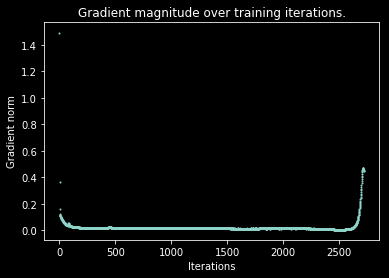

In [66]:
plt.scatter(iteration_vector, gradient_magnitude, s=1)
plt.title('Gradient magnitude over training iterations.')
plt.ylabel('Gradient norm')
plt.xlabel('Iterations')
plt.show()

Let's now visualize the training and validation loss.

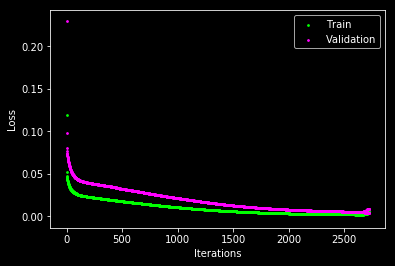

In [67]:
plt.close()
training_loss = mlp_sinc.training_loss
validation_loss = mlp_sinc.validation_loss
plt.scatter(iteration_vector, training_loss, s=3, c='lime', label='Train')
plt.scatter(iteration_vector, validation_loss, s=3, c='fuchsia', label='Validation')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(loc='upper right')
plt.show()

Let's try to see learnt function.

In [68]:
x_range = np.arange(-15,15, 0.05)
sinc_out = np.sin(x_range)/x_range
neuralnetwork_out = mlp_sinc.predict(x_range)

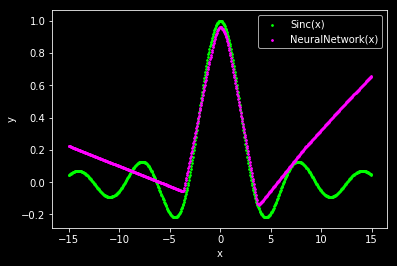

In [69]:
plt.scatter(x_range, sinc_out, s=3, c='lime', label='Sinc(x)')
plt.scatter(x_range, neuralnetwork_out, s=3, c='fuchsia', label='NeuralNetwork(x)')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(loc='upper right')
plt.show()

We can try another dataset, for example the 10 dimensional diabetes regression dataset.

In [70]:
import sklearn.datasets
diabetes = sklearn.datasets.load_diabetes()

In [71]:
print(diabetes.data.shape)
print(diabetes.target.shape)

(442, 10)
(442,)


In [72]:
def split_data_np(features, target, validation_fraction, test_fraction):
    N = features.shape[0]
    inds_shuffled = np.random.permutation(np.arange(0, N))
    train_thresh = int(np.round(inds_shuffled.shape[0] * (1 - test_fraction - validation_fraction)))
    val_thresh = int(np.round(inds_shuffled.shape[0] * (1 - test_fraction)))
    train_inds = inds_shuffled[0:train_thresh]
    val_inds = inds_shuffled[train_thresh:val_thresh]
    test_inds = inds_shuffled[val_thresh:]
    
    trainX = features[train_inds, :]
    trainY = target[train_inds]
    
    valX = features[val_inds, :]
    valY = target[val_inds]
    
    testX = features[test_inds, :]
    testY = target[test_inds]
    
    return dict(trainx=trainX, trainy=trainY, valx=valX, valy=valY, testx=testX, testy=testY)

In [73]:
diabetes_split = split_data_np(diabetes.data, diabetes.target, 0.2, 0.2)

In [74]:
diabetes_nn = mlp_sinc = NNregressor_onelayer(activation_function = 'relu')
diabetes_nn.estimate_weights(diabetes_split['trainx'], diabetes_split['trainy'], diabetes_split['valx'],
                             diabetes_split['valy'], n_hidden=100, 
                              iterations=10000, patience=10, rate=0.001, 
                              verbose=False, weight_initialization_factors=None)

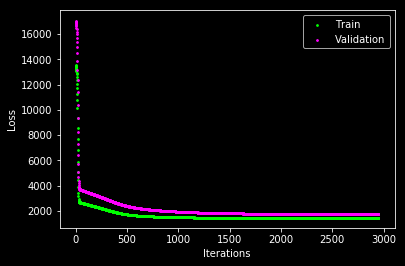

In [75]:
plt.scatter(np.arange(diabetes_nn.iterations), diabetes_nn.training_loss, s=3, c='lime', label='Train')
plt.scatter(np.arange(diabetes_nn.iterations), diabetes_nn.validation_loss, s=3, c='fuchsia', label='Validation')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(loc='upper right')
plt.show()

In [19]:
functools.reduce(lambda x,y: x*y,trainy.shape)

25